### Desmopressin Response Analysis in Hyponatremia Treatment
This analysis examines how desmopressin affects sodium levels in ICU patients with hyponatremia. By tracking the relationship between desmopressin administration and sodium correction rates, we aim to determine whether desmopressin helps maintain safe correction rates (below 0.42 mEq/L per hour). The findings provide strong evidence on if desmopressin should be included in our recommendation model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

# Set up visualization styles
plt.style.use('ggplot')
sns.set_context("talk")
sns.set_palette("colorblind")

# Define paths
mimic_path = "/home/ren.hang/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0cbe22bc-c428-4faa-b876-150c6fa191fc/physionet.org/files/mimiciv/3.1/unzipped/"
icu_path = os.path.join(mimic_path, "icu")
hosp_path = os.path.join(mimic_path, "hosp")
project_dir = os.path.join("/tmp", 'hyponatremia_analysis')
os.makedirs(project_dir, exist_ok=True)

# Set up the analysis parameters
serum_sodium_itemids = [220645, 226534, 228389, 228390]
print(f"Using serum sodium itemids: {serum_sodium_itemids}")

#########################################
# Step 1: Load and prep the dataset
#########################################
print("Loading datasets...")

# 1. Load sodium measurements
print("Loading sodium data from chartevents...")
df = pd.read_csv(os.path.join(icu_path, "chartevents.csv"), 
                 nrows=100000000,
                 usecols=['subject_id', 'stay_id', 'charttime', 'itemid', 'valuenum'])

# Filter for sodium measurements
sodium_df = df[df['itemid'].isin(serum_sodium_itemids)]
sodium_df = sodium_df[sodium_df['valuenum'].notna() & 
                     (sodium_df['valuenum'] > 80) & 
                     (sodium_df['valuenum'] < 180)]
sodium_df['charttime'] = pd.to_datetime(sodium_df['charttime'])

# Identify hyponatremia patients
hyponatremia_patients = sodium_df[sodium_df['valuenum'] < 135]['subject_id'].unique()
hyponatremia_count = len(hyponatremia_patients)
severe_hyponatremia_patients = sodium_df[sodium_df['valuenum'] < 120]['subject_id'].unique()
severe_hyponatremia_count = len(severe_hyponatremia_patients)
print(f"Found {hyponatremia_count} patients with hyponatremia (Na < 135 mEq/L)")
print(f"Found {severe_hyponatremia_count} patients with severe hyponatremia (Na < 120 mEq/L)")

# 2. Load prescriptions data for desmopressin
print("\nLoading prescriptions data...")
prescriptions = pd.read_csv(os.path.join(hosp_path, "prescriptions.csv"))
print(f"Loaded {len(prescriptions)} prescription records")

# Extract desmopressin prescriptions
desmopressin_terms = ["desmopressin", "DDAVP"]
desmopressin_rx = pd.DataFrame()
for term in desmopressin_terms:
    matches = prescriptions[prescriptions['drug'].str.contains(term, case=False, na=False)]
    desmopressin_rx = pd.concat([desmopressin_rx, matches], ignore_index=True)

# Clean the desmopressin data
desmopressin_rx.drop_duplicates(inplace=True)
print(f"Found {len(desmopressin_rx)} desmopressin prescriptions")
desmopressin_rx['starttime'] = pd.to_datetime(desmopressin_rx['starttime'])
desmopressin_rx['stoptime'] = pd.to_datetime(desmopressin_rx['stoptime'])

# Identify patients with both hyponatremia and desmopressin treatment
ddavp_patients = desmopressin_rx['subject_id'].unique()
hyponatremia_ddavp_patients = set(hyponatremia_patients).intersection(set(ddavp_patients))
print(f"Found {len(hyponatremia_ddavp_patients)} patients with both hyponatremia and desmopressin treatment")

# Calculate percentages for all groups
ddavp_percentage = (len(ddavp_patients) / 65366) * 100
ddavp_hypo_percentage = (len(hyponatremia_ddavp_patients) / hyponatremia_count) * 100
ddavp_severe_patients = set(severe_hyponatremia_patients).intersection(set(ddavp_patients))
ddavp_severe_percentage = (len(ddavp_severe_patients) / severe_hyponatremia_count) * 100

# 3. Load urine output data
print("\nLoading urine output data...")
d_items = pd.read_csv(os.path.join(icu_path, "d_items.csv"))
urine_output_items = d_items[(d_items['label'].str.contains('urine|foley', case=False, na=False)) & 
                           (d_items['linksto'] == 'outputevents')]
print(f"Found {len(urine_output_items)} urine output items:")
print(urine_output_items[['itemid', 'label']].head().to_string(index=False))

urine_output_itemids = urine_output_items['itemid'].tolist()
outputevents = pd.read_csv(os.path.join(icu_path, "outputevents.csv"),
                         usecols=['subject_id', 'charttime', 'itemid', 'value', 'valueuom'])

# Filter for urine output measurements
urine_output_df = outputevents[outputevents['itemid'].isin(urine_output_itemids)]
urine_output_df = urine_output_df[urine_output_df['value'].notna()]
urine_output_df['charttime'] = pd.to_datetime(urine_output_df['charttime'])
print(f"Found {len(urine_output_df)} urine output measurements for {urine_output_df['subject_id'].nunique()} patients")

# 4. Load ICU stays data
icustays = pd.read_csv(os.path.join(icu_path, "icustays.csv"))
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])
total_icu_patients = icustays['subject_id'].nunique()
print(f"Loaded {len(icustays)} ICU stays for {total_icu_patients} patients")

Using serum sodium itemids: [220645, 226534, 228389, 228390]
Loading datasets...
Loading sodium data from chartevents...
Found 6006 patients with hyponatremia (Na < 135 mEq/L)
Found 256 patients with severe hyponatremia (Na < 120 mEq/L)

Loading prescriptions data...


/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Loaded 20292611 prescription records
Found 4775 desmopressin prescriptions
Found 281 patients with both hyponatremia and desmopressin treatment

Loading urine output data...
Found 5 urine output items:
 itemid                        label
 226559                        Foley
 226566    Urine and GU Irrigant Out
 226627                     OR Urine
 226631                   PACU Urine
 227489 GU Irrigant/Urine Volume Out
Found 3632792 urine output measurements for 50895 patients
Loaded 94458 ICU stays for 65366 patients


Here, we observe 6006 ICU patients were identified with hyponatremia (Na < 135 mEq/L), including 256 with severe hyponatremia (Na < 120 mEq/L). From over 20 million prescription records, 4775 desmopressin prescriptions were extracted, and 281 patients were found to have both hyponatremia and received desmopressin treatment. Additionally, the dataset includes documentation with over 3.6 million urine output measurements covering roughly 50,900 patients and 94,458 ICU stays among 65,366 unique patients.


Population-level Analysis of Desmopressin Treatment in Hyponatremia
Desmopressin Usage by Patient Group:
               patient_group  total_patients  ddavp_patients  treatment_percentage
            All ICU Patients           65366            2238              3.423798
       Hyponatremia Patients            6006             281              4.678655
Severe Hyponatremia Patients             256              56             21.875000


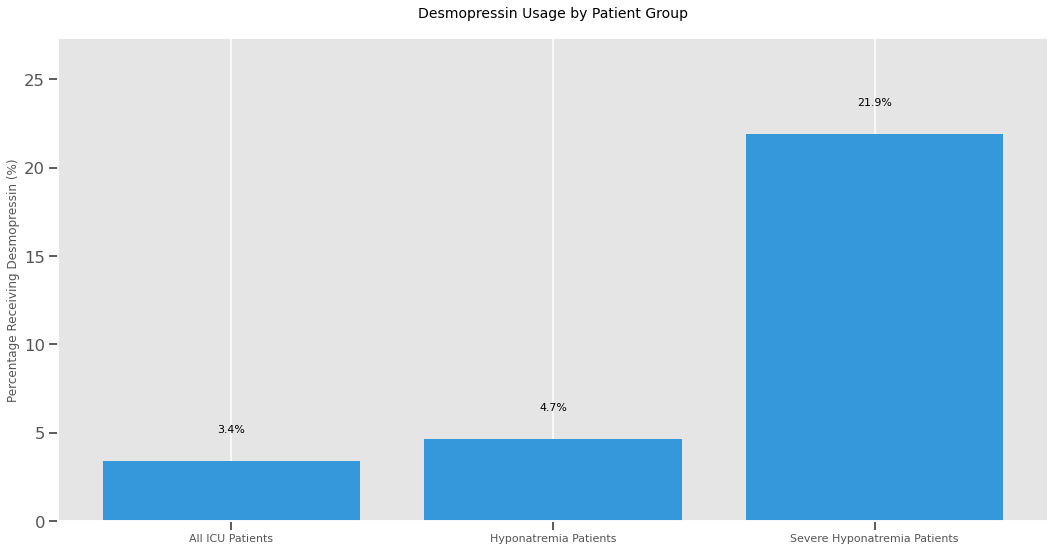

In [5]:
#########################################
# Step 2: Population-level Analysis (Desmopressin Only)
#########################################
print("\n===============================================")
print("Population-level Analysis of Desmopressin Treatment in Hyponatremia")
print("===============================================")

# Create summary dataframe of patient groups and treatment percentages
treatment_summary = pd.DataFrame({
    'patient_group': ['All ICU Patients', 'Hyponatremia Patients', 'Severe Hyponatremia Patients'],
    'total_patients': [total_icu_patients, hyponatremia_count, severe_hyponatremia_count],
    'ddavp_patients': [len(ddavp_patients), len(hyponatremia_ddavp_patients), len(ddavp_severe_patients)],
    'treatment_percentage': [
        (len(ddavp_patients) / total_icu_patients) * 100,
        ddavp_hypo_percentage,
        ddavp_severe_percentage
    ]
})

print("Desmopressin Usage by Patient Group:")
print(treatment_summary.to_string(index=False))

# Visualization for desmopressin usage
plt.figure(figsize=(15, 8))
plt.subplot(1, 1, 1)
bars = plt.bar(treatment_summary['patient_group'], treatment_summary['treatment_percentage'], color='#3498db')
plt.ylabel('Percentage Receiving Desmopressin (%)', fontsize=12)
plt.title('Desmopressin Usage by Patient Group', fontsize=14, pad=20)
plt.xticks(rotation=0, fontsize=11)
plt.ylim(0, max(treatment_summary['treatment_percentage']) * 1.25)
plt.grid(axis='y', alpha=0.3)

# Add labels
for bar, value in zip(bars, treatment_summary['treatment_percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1.5, f'{value:.1f}%', 
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('desmopressin_treatment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


**Results:**  
- Out of 65,366 total ICU patients, 3.4% (2,238) received desmopressin.  
- Of the 6,006 patients with hyponatremia, 4.7% (281) were on desmopressin.  
- Among the 256 patients with severe hyponatremia, 21.9% (56) received desmopressin.  
- This steady increase pattern in desmopressin use indicates clinicians are more likely to prescribe it when hyponatremia is more acute, especially for severe hyponatremia patients.


Sodium Correction Rate Analysis
Found 418 patients with both sodium measurements and desmopressin
Analyzing episodes for up to 418 patients...

Sodium Correction Rate Analysis (Before Outlier Removal for Plotting):
Episodes with desmopressin: 128
Average correction rate with desmopressin: 0.159 mEq/L per hour
Percentage of safe corrections with desmopressin: 92.2%

Episodes without desmopressin: 882
Average correction rate without desmopressin: 1.078 mEq/L per hour
Percentage of safe corrections without desmopressin: 74.9%


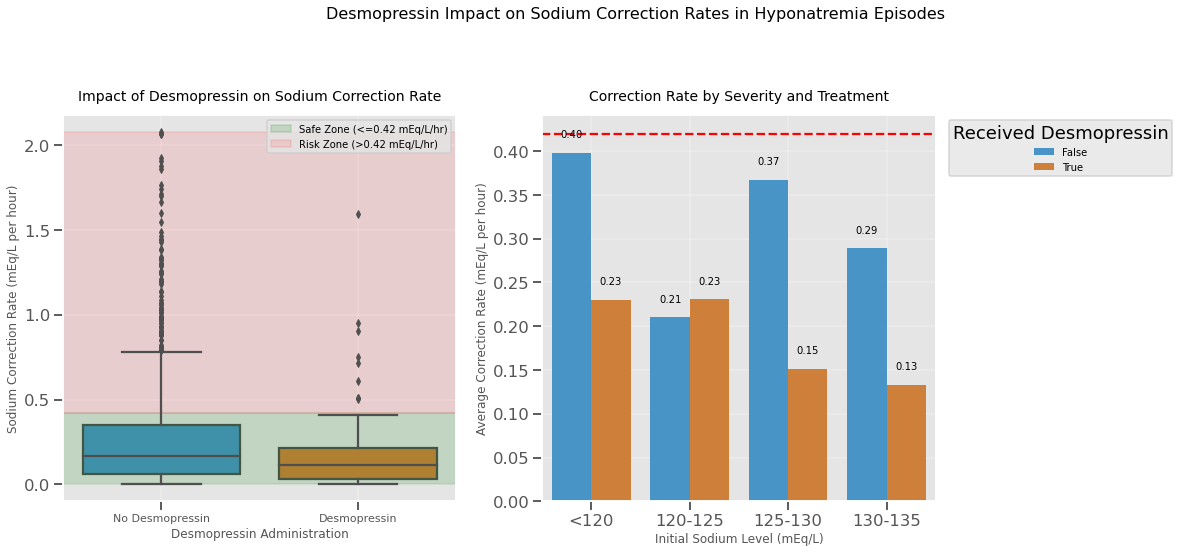


Safety Analysis Results:
Percentage of desmopressin episodes with safe correction rate (<= 0.42 mEq/L/hr): 92.2%
Percentage of non-desmopressin episodes with safe correction rate (<= 0.42 mEq/L/hr): 74.9%


In [4]:
#########################################
# Step 3: Sodium Correction Rate Analysis
#########################################

print("\n===============================================")
print("Sodium Correction Rate Analysis")
print("===============================================")

# Find patients with both sodium measurements and desmopressin
sodium_patients = set(sodium_df['subject_id'].unique())
desmopressin_patients = set(desmopressin_rx['subject_id'].unique())
analysis_patients = sodium_patients.intersection(desmopressin_patients)

print(f"Found {len(analysis_patients)} patients with both sodium measurements and desmopressin")

# For each patient, determine if they received desmopressin during a hyponatremic episode
hyponatremia_episodes = []

patient_list_limit = len(analysis_patients)
print(f"Analyzing episodes for up to {patient_list_limit} patients...")

for patient_id in list(analysis_patients)[:patient_list_limit]:
    # Get patient's sodium measurements
    patient_sodium = sodium_df[sodium_df['subject_id'] == patient_id].copy()
    if len(patient_sodium) < 2: continue
    patient_sodium.sort_values('charttime', inplace=True)

    # Get desmopressin administrations
    patient_ddavp = desmopressin_rx[desmopressin_rx['subject_id'] == patient_id].copy()

    # Check if patient had any hyponatremia
    if any(patient_sodium['valuenum'] < 135):
        # Find episodes of hyponatremia
        episode_start_indices = []
        in_episode = False
        for i in range(len(patient_sodium)):
            is_hypo = patient_sodium.iloc[i]['valuenum'] < 135
            if is_hypo and not in_episode:
                episode_start_indices.append(i)
                in_episode = True
            elif not is_hypo:
                in_episode = False

        # Process each episode
        for start_idx in episode_start_indices:
            episode_data = {}
            episode_data['patient_id'] = patient_id
            episode_data['episode_start'] = patient_sodium.iloc[start_idx]['charttime']
            episode_data['start_na'] = patient_sodium.iloc[start_idx]['valuenum']

            # Find the end of the episode
            end_idx = None
            for i in range(start_idx + 1, len(patient_sodium)):
                if patient_sodium.iloc[i]['valuenum'] >= 135:
                    end_idx = i
                    break

            if end_idx is not None:
                episode_data['episode_end'] = patient_sodium.iloc[end_idx]['charttime']
                episode_data['end_na'] = patient_sodium.iloc[end_idx]['valuenum']
            else:
                last_idx = len(patient_sodium) - 1
                if last_idx > start_idx:
                    episode_data['episode_end'] = patient_sodium.iloc[last_idx]['charttime']
                    episode_data['end_na'] = patient_sodium.iloc[last_idx]['valuenum']
                else:
                    continue

            duration = (episode_data['episode_end'] - episode_data['episode_start']).total_seconds() / (60*60)
            episode_data['duration_hours'] = duration

            if duration <= 0: continue

            # Calculate correction rate
            correction = episode_data['end_na'] - episode_data['start_na']
            episode_data['correction'] = correction
            episode_data['correction_rate'] = correction / duration

            # Check if desmopressin was given during this episode
            if not patient_ddavp.empty:
                 episode_ddavp_during = patient_ddavp[
                    (patient_ddavp['starttime'] >= episode_data['episode_start']) &
                    (patient_ddavp['starttime'] <= episode_data['episode_end'])
                 ]
                 episode_data['received_ddavp'] = len(episode_ddavp_during) > 0
            else:
                 episode_data['received_ddavp'] = False

            hyponatremia_episodes.append(episode_data)

# Convert to DataFrame
episodes_df = pd.DataFrame(hyponatremia_episodes)

# Clean and filter the data for analysis
episodes_df = episodes_df.dropna(subset=['correction_rate'])
episodes_df = episodes_df[np.isfinite(episodes_df['correction_rate'])]

# --- Calculate Stats Before Outlier Removal for Plotting ---
print("\nSodium Correction Rate Analysis (Before Outlier Removal for Plotting):")
ddavp_episodes_full = episodes_df[episodes_df['received_ddavp']]
non_ddavp_episodes_full = episodes_df[~episodes_df['received_ddavp']]

print(f"Episodes with desmopressin: {len(ddavp_episodes_full)}")
avg_ddavp_rate = ddavp_episodes_full['correction_rate'].mean()
print(f"Average correction rate with desmopressin: {avg_ddavp_rate:.3f} mEq/L per hour")
safe_threshold = 0.42 # mEq/L per hour
ddavp_safe_pct = (ddavp_episodes_full['correction_rate'] <= safe_threshold).mean() * 100
print(f"Percentage of safe corrections with desmopressin: {ddavp_safe_pct:.1f}%")

print(f"\nEpisodes without desmopressin: {len(non_ddavp_episodes_full)}")
avg_non_ddavp_rate = non_ddavp_episodes_full['correction_rate'].mean()
print(f"Average correction rate without desmopressin: {avg_non_ddavp_rate:.3f} mEq/L per hour")
non_ddavp_safe_pct = (non_ddavp_episodes_full['correction_rate'] <= safe_threshold).mean() * 100
print(f"Percentage of safe corrections without desmopressin: {non_ddavp_safe_pct:.1f}%")

# --- Filter for Plotting ---
lower_bound = episodes_df['correction_rate'].quantile(0.05)
upper_bound = episodes_df['correction_rate'].quantile(0.95)
if upper_bound > lower_bound:
     episodes_df_plot = episodes_df[episodes_df['correction_rate'].between(lower_bound, upper_bound)].copy()
else:
     episodes_df_plot = episodes_df.copy()

# --- Plotting Starts ---
plt.style.use('ggplot')
sns.set_context("talk")
sns.set_palette("colorblind")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Desmopressin Impact on Sodium Correction Rates in Hyponatremia Episodes', fontsize=16, y=1.0) # Lowered suptitle slightly

# Plot 1: Correction rate comparison with boxplot
ax1 = axes[0]
sns.boxplot(x='received_ddavp', y='correction_rate', data=episodes_df_plot,
                  palette=['#3498db', '#e67e22'], ax=ax1)
ax1.set_xlabel('Desmopressin Administration', fontsize=12)
ax1.set_ylabel('Sodium Correction Rate (mEq/L per hour)', fontsize=12)
ax1.set_title('Impact of Desmopressin on Sodium Correction Rate', fontsize=14, pad=15)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['No Desmopressin', 'Desmopressin'], fontsize=11)
ax1.grid(True, alpha=0.3)

# Set y-axis limits
y_min_plot = max(episodes_df_plot['correction_rate'].min(), -0.5)
y_max_plot = min(episodes_df_plot['correction_rate'].max(), 2.5)
ax1.set_ylim(y_min_plot - 0.1, y_max_plot + 0.1)

# Highlight the safe correction zone
safe_zone_max = min(y_max_plot, safe_threshold)
risk_zone_min = max(y_min_plot, safe_threshold)

ax1.axhspan(0, safe_zone_max, color='green', alpha=0.15, label='Safe Zone (<=0.42 mEq/L/hr)')
if y_max_plot > safe_threshold:
    ax1.axhspan(risk_zone_min, y_max_plot, color='red', alpha=0.1, label='Risk Zone (>0.42 mEq/L/hr)')

ax1.legend(fontsize=10, loc='upper right')

# Plot 2: Correction rate by severity and treatment
ax2 = axes[1]

# Create severity groups
episodes_df_plot['severity'] = pd.cut(
    episodes_df_plot['start_na'],
    bins=[0, 120, 125, 130, 135],
    labels=['<120', '120-125', '125-130', '130-135'],
    right=False
)
episodes_df_plot_grouped = episodes_df_plot.dropna(subset=['severity']).copy()

# Calculate average rates by group
avg_by_group = episodes_df_plot_grouped.groupby(['severity', 'received_ddavp'], observed=False)['correction_rate'].mean().reset_index()

# Create the bar plot
sns.barplot(x='severity', y='correction_rate', hue='received_ddavp',
                 data=avg_by_group, palette=['#3498db', '#e67e22'], ax=ax2)
ax2.set_xlabel('Initial Sodium Level (mEq/L)', fontsize=12)
ax2.set_ylabel('Average Correction Rate (mEq/L per hour)', fontsize=12)
ax2.set_title('Correction Rate by Severity and Treatment', fontsize=14, pad=15)

# Add horizontal line at safe threshold
ax2.axhline(y=safe_threshold, color='red', linestyle='--')

# Create legend
handles, labels = ax2.get_legend_handles_labels()
hue_map = {False: 'No', True: 'Yes'}
new_labels = [hue_map.get(l, l) for l in labels[:2]]

ax2.legend(handles=handles[:2], labels=new_labels,
           title='Received Desmopressin',
           fontsize=10,
           loc='upper left',
           bbox_to_anchor=(1.02, 1)) # Position legend outside

ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

label_offset = 0.015
for bar in ax2.patches:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height + label_offset,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 0.93, 0.95])

plt.savefig('desmopressin_correction_analysis_corrected_v4.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSafety Analysis Results:")
print(f"Percentage of desmopressin episodes with safe correction rate (<= {safe_threshold} mEq/L/hr): {ddavp_safe_pct:.1f}%")
print(f"Percentage of non-desmopressin episodes with safe correction rate (<= {safe_threshold} mEq/L/hr): {non_ddavp_safe_pct:.1f}%")

**Impact of Desmopressin on Sodium Correction Rate Summary:**
In the boxplot on left, we compare the distribution of sodium correction rates in hyponatremia episodes with versus without desmopressin. It shows that episodes with desmopressin have a lower median correction rate and less spread, with most values falling within the safe range (≤ 0.42 mEq/L/hr). In contrast, episodes without desmopressin display a higher median and more variability, with a larger proportion exceeding the safe threshold.

**Correction Rate by Severity Summary:**
The bar plot on right breaks down the average sodium correction rates across different initial sodium severity bins and contrasts treatment groups. It demonstrates that within each initial sodium range, episodes with desmopressin consistently have lower average correction rates compared to those without, reinforcing that desmopressin administration is associated with slower, safer sodium corrections regardless of baseline severity.

Therefore, we designing our recommendation model, to prevent patients from too fast sodium correction rate and thus cause brain damage, it's helpful to take Desmopressin into consideration